<div style="text-align: center;">
    <h1>AI Project 3</h1>
</div>

<div style="text-align: center;">
    Farbod Azimmohseni 810100187
</div>

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from hmmlearn import hmm
from python_speech_features import mfcc
from scipy.io import wavfile
import speechpy
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from tabulate import tabulate
from scipy.stats import multivariate_normal


In [30]:
music_style = ['blues', 'hiphop', 'metal', 'pop']
style_numbers = len(music_style)
min_len = 2900


In [31]:
def confusion_matrix(predictions):
    c_matrix = [[0]*style_numbers for i in range(style_numbers)]
    for pred in predictions:
        y_pred,y_real = pred
        for i,s_i in enumerate(music_style):
            if s_i == y_real:
                for j,s_j in enumerate(music_style):
                    if s_j == y_pred:
                        c_matrix[i][j] += 1
    return c_matrix

                
            

In [32]:
def two_digit(x):
    if x < 10:
        return f"0{x}"
    else:
        return f"{x}"
    
    

In [33]:
def argmax(arr):
    max_value = arr[0]
    max_index = 0

    for i in range(1, len(arr)):
        if arr[i] > max_value:
            max_value = arr[i]
            max_index = i

    return max_index


# <font color='cyan'>Preprocessing</font>




In [34]:
# def find_min_len():
#     min = np.inf
#     for i in range(style_numbers):
#         for j in range(100):
#             sampling_freq, audio = wavfile.read(f"dataset/{music_style[i]}/{music_style[i]}.000{two_digit(j)}.wav")
#             coefs = mfcc(audio, sampling_freq ,nfft=1024)
#             if(coefs.shape[0] < min):
#                 min = coefs.shape[0]
#     return min


# print(find_min_len())



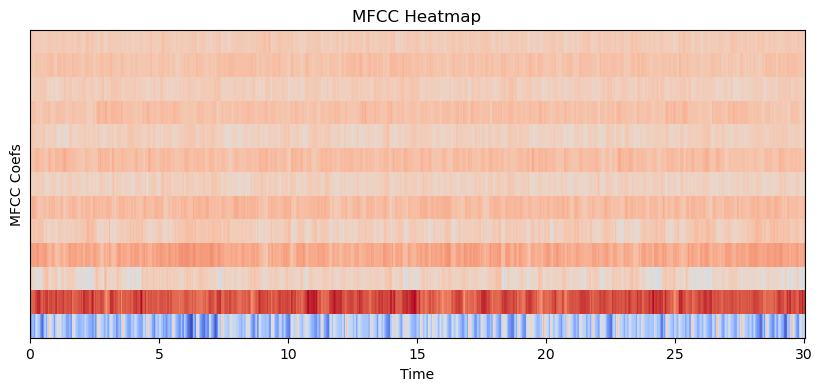

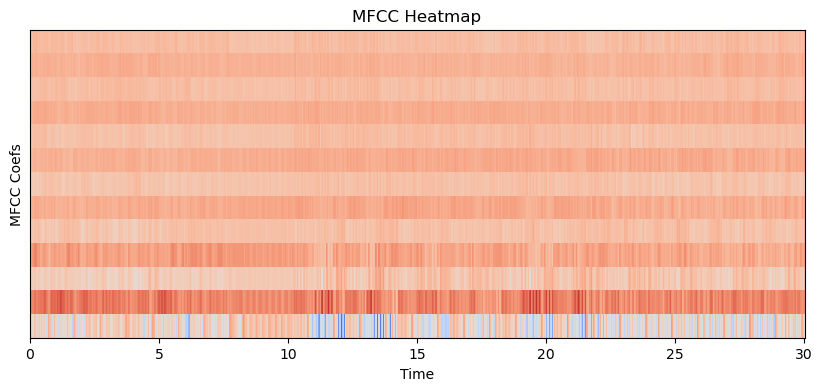

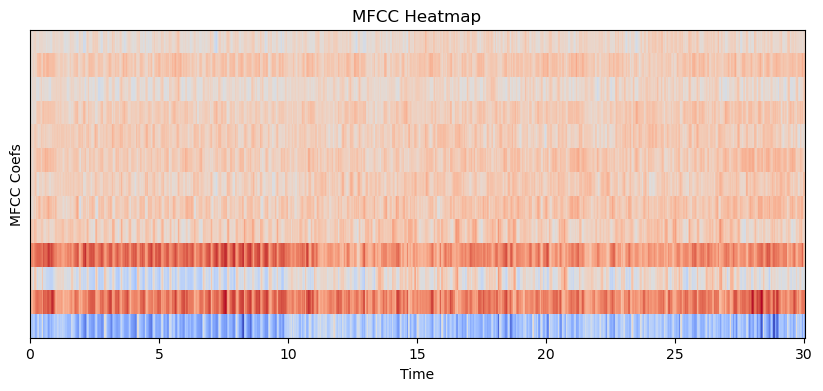

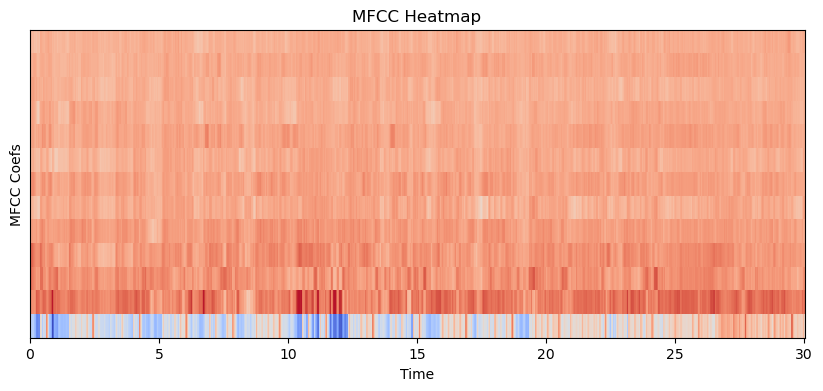

In [35]:

for i in range(style_numbers):
    y, sr = librosa.load(f"dataset/{music_style[i]}/{music_style[i]}.00000.wav")
    coefs  = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=13)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(coefs, x_axis='time')
    plt.title('MFCC Heatmap')
    plt.ylabel('MFCC Coefs')
    plt.show()
        


<font color='yellow'>1.</font>We usually make all inputs the same size in this type of models in case our model is sensitive to the size of the model. The most important reason is that most of the calculations are done in matrix form for faster computation and different input sizes will result in error.

<font color='yellow'>2.</font> Mfcc frames are in a form of winodws that may last for multiple frames. This will form a better representation of audio file.

<font color='yellow'>3.</font> This decision will reduce dimensionality of our data to lower computational cost. Also,  human voice is mostly covered in this range.

# <font color='cyan'>Introduction to HMM</font>


<font color='yellow'>1.</font> States are hiddend states that our model be at each state. Each state has a chance of moving to another state or staying there at each step. These probability is known as transition chance. Observations are noisy inputs that help us find the next state of our model. Difference between Markov and Hidden Markov is in observations. In markov model at each time step($q_{i}$) we know the state of we are in but in hidden markov we are trying to guess these states. In our model we have T observations which are frames of the audio. Each frame has 13 coefficients which are symbols of our model. In order to fit this for our model we need to find the distribution of these coefficients. Our states can be anything and we can have as much states as we want because goal of this problem is to find the probability of a sequence fitting our model not finding the state we will be in.

<font color='yellow'>2.</font> This is a first order hmm because each hidden state has one observation connected to it and hidden states are connected in form of a simple markov chain. This model is simple and only consider that current state only depends on the past. First order hmm has low compitational cost. It has the ability to model many types of situations and works well when our sequence have a short term depenency. More complex models can be utilized to handle situations where our relations are not really simple. 

<font color='yellow'>3.</font>Hmm works well on sequential data and problems like pattern recognition(audio analysis, handwriting recognition,etc...). Commonly when we have different type of dependencies in our model hmm can be used.


<font color='yellow'>4.</font> 

Advantages:

Flexibility of hmm has made it popular for wide range of problems. Unlike neural networks,hmm has a high interpretability and we can easily understand it. Low computational cost is another advantage of this model.

Disadvatages:

Simplicity of this model makes it limited for complex data. It also requires sufficient amount of data for good results.
Another problem is that different initial parameters may lead to different answers.

<font color='yellow'>5.</font> There can be other structures for example hierarchical hmm. This model is used when there exist a hierarchy in the sequence and each state captures some level of it. high level hmm is another structure which is capable for capturing complex features of data.

In [36]:
file_paths = []
lables = []
for i in range(style_numbers):
    for j in range(100):
        file_paths.append(f"dataset/{music_style[i]}/{music_style[i]}.000{two_digit(j)}.wav")
        lables.append(music_style[i])

In [37]:
def hmm_train(file_paths):
  hmm_model_results = []
  test_list = []
  for i in range(style_numbers):
      # x_train = []
      x_train = np.array([])
      x_train_paths ,x_test_paths,y_train_lables,y_test_lables = train_test_split(file_paths[100*i:100*(i+1)],lables[100*i:100*(i+1)],test_size=0.3)
      for k in range(len(x_test_paths)):
        test_list.append((x_test_paths[k],y_test_lables[k]))

      for j in range(len(x_train_paths)):
          sampling_freq, audio = wavfile.read(x_train_paths[j])
          coefs = mfcc(audio, sampling_freq ,nfft=1024)[:2900,:]
          # coefs = speechpy.processing.cmvn(coefs,variance_normalization=True)
          if j == 0:
            x_train = coefs[:min_len,:]
          else:
            x_train = np.append(x_train,coefs[:min_len,:],axis = 0)
      model = hmm.GaussianHMM(n_components=4,covariance_type='diag',n_iter=12)
      model.fit(x_train)
      hmm_model_results.append(model)

  return hmm_model_results,test_list
  


    


In [38]:
def evaluate(hmm_model_results,test_list,mode):
    accu = 0

    results = []
    for i in range(len(test_list)):
        path, lable = test_list[i]
        sampling_freq, audio = wavfile.read(path)
        coefs = mfcc(audio, sampling_freq ,nfft=1024)[:2900,:]
        # coefs = speechpy.processing.cmvn(coefs[:2900,:],variance_normalization=True)
        model_prob = []
        for j in range(style_numbers):
            if mode =="library hmm":
                prob = hmm_model_results[j].score(coefs)
            else:
                prob = hmm_model_results[j].score(coefs.T/np.amax(coefs.T))
            model_prob.append(prob)
        results.append((music_style[argmax(model_prob)],lable))
        if lable == music_style[argmax(model_prob)]:
            accu +=1 


    c_matrix = confusion_matrix(results)




    plt.figure(figsize=(8, 6))
    sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=music_style, yticklabels=music_style)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')


    style_result = dict()
    for style in music_style:
        Tp = 0
        Fp = 0
        Fn = 0
        for res in results:
            pred,real = res
            if pred == style and real == pred:
                Tp += 1
            elif pred == style and real != pred:
                Fp += 1
            elif real == style and pred != real:
                Fn +=1
        style_result[style] = (Tp,Fp,Fn)


    metrics = ["Precision","Recall","F1"]
    class_metrics = [[] for i in range(style_numbers)]
    macro_precision = 0
    macro_recall =0
    tp_s = 0
    fp_s = 0
    fn_s = 0
    f_1_s =0
    for i in range(style_numbers):
        tp,fp,fn, = style_result[music_style[i]]
        class_metrics[i].append(music_style[i])
        class_metrics[i].append(tp/(tp+fp))
        class_metrics[i].append(tp/(tp+fn))
        class_metrics[i].append((2*(class_metrics[i][1])*(class_metrics[i][2]))/(class_metrics[i][1]+class_metrics[i][2]))
        macro_recall += class_metrics[i][2]
        macro_precision += class_metrics[i][1]
        tp_s += tp
        fp_s += fp
        fn_s += fn
        f_1_s += class_metrics[i][3]


    print(tabulate(class_metrics, metrics, tablefmt='fancy_grid'))
    print(f"total accuracy: {accu/len(test_list)}")

    print(f"micro precision: {tp_s/(tp_s + fp_s)} micro recall: {tp_s/(tp_s+fn_s)}")
    print(f"macro precision: {macro_precision/style_numbers} macro recall: {macro_recall/style_numbers}")
    print(f"average F1: {f_1_s/style_numbers}")

    





╒════════╤═════════════╤══════════╤══════════╕
│        │   Precision │   Recall │       F1 │
╞════════╪═════════════╪══════════╪══════════╡
│ blues  │    0.787879 │ 0.866667 │ 0.825397 │
├────────┼─────────────┼──────────┼──────────┤
│ hiphop │    0.846154 │ 0.733333 │ 0.785714 │
├────────┼─────────────┼──────────┼──────────┤
│ metal  │    0.866667 │ 0.866667 │ 0.866667 │
├────────┼─────────────┼──────────┼──────────┤
│ pop    │    0.935484 │ 0.966667 │ 0.95082  │
╘════════╧═════════════╧══════════╧══════════╛
total accuracy: 0.8583333333333333
micro precision: 0.8583333333333333 micro recall: 0.8583333333333333
macro precision: 0.8590457929167606 macro recall: 0.8583333333333334
average F1: 0.8571493624772314


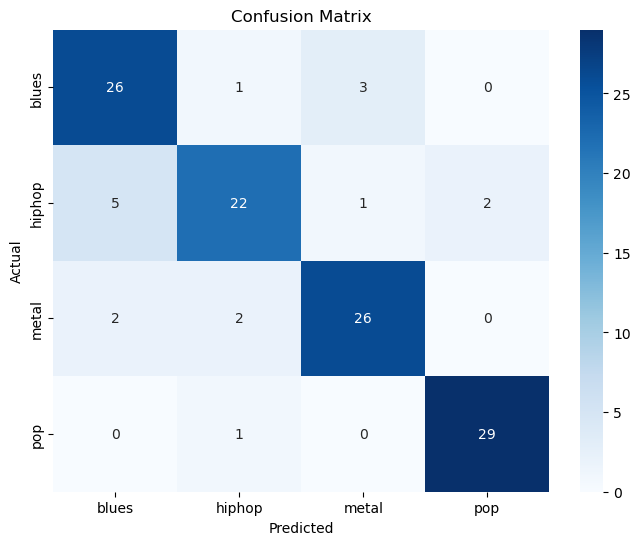

In [39]:
hmm_model_results,test_list = hmm_train(file_paths)
evaluate(hmm_model_results,test_list,"library hmm")

In [40]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]
            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] =  np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]
        B = self._state_likelihood(obs)
        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)-

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=10):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [41]:
def our_hmm(file_paths):
  hmm_model_results = []
  test_list = []
  for i in range(style_numbers):
      # x_train = []
      x_train = np.array([])
      x_train_paths ,x_test_paths,y_train_lables,y_test_lables = train_test_split(file_paths[100*i:100*(i+1)],lables[100*i:100*(i+1)],test_size=0.3)
      for k in range(len(x_test_paths)):
        test_list.append((x_test_paths[k],y_test_lables[k]))

      for j in range(len(x_train_paths)):
          sampling_freq, audio = wavfile.read(x_train_paths[j])
          coefs = mfcc(audio, sampling_freq ,nfft=1024)[:2900,:]
          # coefs = speechpy.processing.cmvn(coefs,variance_normalization=True)
          if j == 0:
            x_train = coefs[:min_len,:]
          else:
            x_train = np.append(x_train,coefs,axis = 0)
      model = HMM(4)
      model.train(x_train.T/np.amax(x_train.T),2)
      hmm_model_results.append(model)
  return hmm_model_results,test_list
    






In [42]:
hmm_model_results,test_list = our_hmm(file_paths)

╒════════╤═════════════╤══════════╤══════════╕
│        │   Precision │   Recall │       F1 │
╞════════╪═════════════╪══════════╪══════════╡
│ blues  │    0.791667 │ 0.633333 │ 0.703704 │
├────────┼─────────────┼──────────┼──────────┤
│ hiphop │    0.769231 │ 0.333333 │ 0.465116 │
├────────┼─────────────┼──────────┼──────────┤
│ metal  │    0.595745 │ 0.933333 │ 0.727273 │
├────────┼─────────────┼──────────┼──────────┤
│ pop    │    0.777778 │ 0.933333 │ 0.848485 │
╘════════╧═════════════╧══════════╧══════════╛
total accuracy: 0.7083333333333334
micro precision: 0.7083333333333334 micro recall: 0.7083333333333334
macro precision: 0.7336049736315693 macro recall: 0.7083333333333333
average F1: 0.6861443896327617


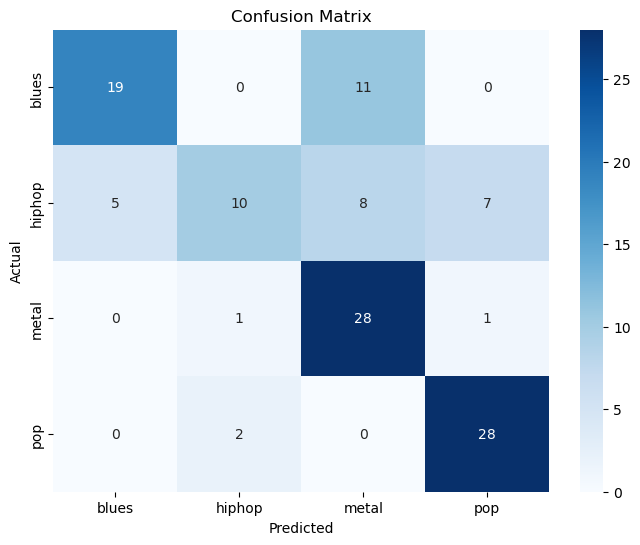

In [43]:
evaluate(hmm_model_results,test_list,"writen hmm")


# <font color='cyan'>Measuring the model</font>


<font color='yellow'>1.</font> Acuuracy measures the proportion of correct predictions in the model. This measure may not be enough because in multiclass classification, our prediction on some classes are really good but our model is predictiong one class horribly. As a result we need more accurate measurements.

$Accuracy = \frac{True Predictions}{All Predictions}$

precision for each class precision is the proportion of the true positive predictions out of all positive-predicted data.

$Precision = \frac{True Positive}{True Positive + False Positive}$

On the other hand recall is the proportion of true positive predictions out of actually positive data.

$Recall = \frac{True Positive}{True Positive + False Negative}$

Finally F1 score is a balanced evaluation of Recall and precision and shows performance of the model. F1 score has a  value between 0 and 1.

$F1  = 2* \frac{Recall * Precision}{Recall + Precision}$


<font color='yellow'>2.</font> Precision shows  portion of  positive preidicted data over all positive predicted samples. On the other side Recall shows portion of our positive predicted data over all trully positive data. For example if we have set of 10 data that 7 of them are positive and our model predict all of them positive, then our Precision is 0.7 but our Recall is 1 and with only Recall we would have thought that our model is doing perfect. On the other side if we have 10 samples that 7 of them are positive and our model predict one of these 7 positive and all other 9 negative then we wont have any False Positive prediction and our Precision is 1 but our Recall will be 0.14 So we need both of these metrics.

<font color='yellow'>3.</font> F1 score gives a harmonic importance to both Recall and Precision. This calculation is especially decent in imbalance datasets where the portion of negative and positive samples are not balanced. Furthuremore because of harmonic mean calculation F1 is less sensitive to exrtreme and noisy data.

<font color='yellow'>4.</font> These metrics give a evaluation for each class. To calculate total performance of our model we can use micro-average, macro-average and weighted-average.

$Total Precision Micro = \frac{\sum_{i=1}^{N_1} TP_i}{\sum_{i=1}^{N_1} TP_i + \sum_{i=1}^{N_2} FP_i} $

$Total Precision Macro = \frac{\sum_{i=1}^{N} Precision_{i}}{N} $

$Total Precision Weighted = \frac{\sum_{i=1}^{N} (\alpha_{i} * Precision_{i})}{\sum_{i=1}^{N} \alpha_{i}} $


macro average calculates precision or recall of each class and averages over them. in micro we average TP, NP, and FN. Then calculate the precision and recall. Micro averages along each instance while macro averages along each class.
weighted average is like macro average but when we want to give some classes more or less importance.

<font color='yellow'>6.</font> Our second model does not do well on Hiphop genre but it might because of the low iterations. I tried different values for iteration and 12 or 13 iterations seemed to have the best result.

<font color='yellow'>7.</font> The library model may use different hmm structures or do some hyperparamether optimization
for better results. It can also run more complex algorithms efficiently. The most important thing is how the library model map observations to $ B $ matrix. 